Library Imports and Initializations

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from keras.layers import *
from keras import backend as K
import os
import random
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
DRIVE_PATH = '/content/gdrive'
FOLDER_PATH = '/content/gdrive/MyDrive/CS 577/Processed_Dataset/'
drive.mount(DRIVE_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data Generator Creation

['Trained_Models', 'training', 'testing', 'validation']
(2, 256, 256, 3) (2, 256, 256, 1)


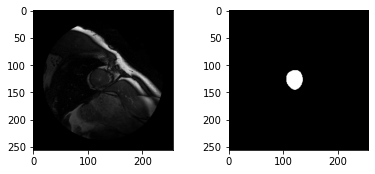

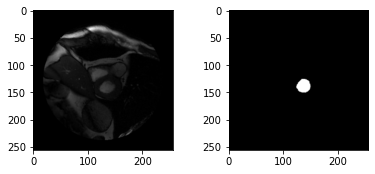

In [9]:
# Creating custom data generator for data loading
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=2, image_size=256):
        self.ids = ids
        self.path = FOLDER_PATH + path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", "img" , id_name)
        mask_path = os.path.join(self.path, "mask", "img", id_name)
        all_masks = [mask_path]
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        # image = np.expand_dims(image, axis=-1)
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = name
            _mask_image = cv2.imread(_mask_path, cv2.IMREAD_GRAYSCALE)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))


def check_images():
    image_size = 256
    train_path = FOLDER_PATH + "training/images/img"
    test_path = FOLDER_PATH + "testing/images/img"
    validation_path = FOLDER_PATH + "validation/images/img"
    epochs = 10
    batch_size = 2

      ## Training Ids

    train_ids = os.listdir(train_path)
    validation_ids = os.listdir(validation_path)
    test_ids = os.listdir(test_path)
    gen = DataGen(train_ids, "training/", batch_size=batch_size, image_size=image_size)
    x, y = gen.__getitem__(0)
    print(x.shape, y.shape)
    r = random.randint(0, len(x)-1)

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.reshape(x[0], (image_size, image_size, 3)), cmap="gray")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(y[0], (image_size, image_size)), cmap="gray")
    plt.show()

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.reshape(x[1], (image_size, image_size, 3)), cmap="gray")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(y[1], (image_size, image_size)), cmap="gray")
    plt.show()
print(os.listdir(FOLDER_PATH))
check_images()

In [ ]:
def train_data_aug(batch_size = 2):
    seed = 1
    image_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05, 
                    height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                    horizontal_flip=True, fill_mode='nearest') 
    mask_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05,
                    height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                    horizontal_flip=True, fill_mode='nearest')  
    dir = FOLDER_PATH + 'training/'
    image_generator = image_datagen.flow_from_directory(dir + 'images', class_mode=None, seed=seed, 
                    color_mode="grayscale", target_size=(256,256), batch_size=batch_size)
    mask_generator = mask_datagen.flow_from_directory(dir + 'mask', class_mode=None, seed=seed, 
                    color_mode="grayscale", target_size=(256,256), batch_size=batch_size)
    train_generator = zip(image_generator, mask_generator) 
    return train_generator

def test_data_aug():
    seed = 1
    image_datagen = ImageDataGenerator(rescale=1./255)
    mask_datagen = ImageDataGenerator(rescale=1./255)  
    dir = FOLDER_PATH + 'testing/'
    image_generator = image_datagen.flow_from_directory(dir + 'images', shuffle=False, class_mode=None, 
                    seed=seed, color_mode="grayscale", target_size=(256,256), batch_size=1)
    mask_generator = mask_datagen.flow_from_directory(dir + 'mask', shuffle=False, class_mode=None, 
                    seed=seed, color_mode="grayscale", target_size=(256,256), batch_size=1)
    test_generator = zip(image_generator, mask_generator) 
    return test_generator

In [ ]:
def check_data_generator_images(c = 0):
    f, axarr = plt.subplots(1,2, figsize=(15, 15))
    for i in train_data_aug():
        if c >= 20:
            break
    im = i[0][0][:,:,0]
    ms = i[1][0][:,:,0]
    axarr[0].imshow(im)
    axarr[1].imshow(ms)
    c += 1
plt.show()

Half-Unet architecture With Batch Normalization (best variant of Half-Unet)

In [ ]:
# code for Half-UNet architecture based on the research paper
def ghost_module(inputs):
    conv1 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    conv2 = SeparableConv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(act1)
    return concatenate([act1, conv2], axis = 3)

def model(input_shape = (256, 256, 1)):

    inputs = Input(shape=input_shape, name="image")
    x1 = ghost_module(ghost_module(inputs))
    pool1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x2 = ghost_module(ghost_module(pool1))
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = ghost_module(ghost_module(pool2))
    pool3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x4 = ghost_module(ghost_module(pool3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x5 = ghost_module(ghost_module(pool4))

    up5 = UpSampling2D(size = (input_shape[0] // x5.shape[1], input_shape[1] // x5.shape[2]))(x5)
    up4 = UpSampling2D(size = (input_shape[0] // x4.shape[1], input_shape[1] // x4.shape[2]))(x4)
    up3 = UpSampling2D(size = (input_shape[0] // x3.shape[1], input_shape[1] // x3.shape[2]))(x3)
    up2 = UpSampling2D(size = (input_shape[0] // x2.shape[1], input_shape[1] // x2.shape[2]))(x2)

    upScaled = Add()([x1, up2, up3, up4, up5])
    all_conv = ghost_module(ghost_module(upScaled))
    final_conv = Conv2D(1, 1, activation = 'sigmoid')(all_conv)
  
    # final_conv = Conv2D(2, (1, 1), activation = 'softmax')(all_conv)
    half_unet_model = tf.keras.Model(inputs, final_conv, name="Half-UNet")
    return half_unet_model

UNet Architecture

In [ ]:
#code for base version of UNet Architecture 
from keras.models import Model

def main_conv_block(input, num):
    conv = Activation("relu")(BatchNormalization()(Conv2D(num, 3, padding="same")(input)))
    conv = Activation("relu")(BatchNormalization()(Conv2D(num, 3, padding="same")(conv)))
    return conv

def left_block(input, num):
    conv = main_conv_block(input, num)
    pool = MaxPool2D((2, 2))(conv)
    return conv, pool

def right_block(input, skip_connect, num):
    conv = main_conv_block(Concatenate()([Conv2DTranspose(num, (2, 2), strides=2, padding="same")(input), skip_connect]), num)
    return conv

def unet_model(input_shape = (256, 256, 3)):
    inputs = Input(input_shape)

    conv1, pool1 = left_block(inputs, 64)
    conv2, pool2 = left_block(pool1, 128)
    conv3, pool3 = left_block(pool2, 256)
    conv4, pool4 = left_block(pool3, 512)

    bottlneck = main_conv_block(pool4, 1024)

    out1 = right_block(bottlneck, conv4, 512)
    out2 = right_block(out1, conv3, 256)
    out3 = right_block(out2, conv2, 128)
    out4 = right_block(out3, conv1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(out4)

    model = Model(inputs, outputs, name="U-Net")
    return model

Nested Half-Unet Model

In [ ]:
#code for Nested Half-UNet architecture based on U^2-Net

def half_unet_block(inputs):
    x1 = ghost_module(ghost_module(inputs))
    return x1, MaxPooling2D(pool_size=(2, 2))(x1)

def half_unet_model_modified(inp, depth = 5, input_shape = 256):
    all_skips = []
    for dp in range(depth):
        x, p = half_unet_block(inp)
        inp = p
        all_skips.append(x)
    layers_to_add = []
    for i, skip in enumerate(all_skips):
        if i == 0:
            layers_to_add.append(skip)
            continue
    up = UpSampling2D(size = (input_shape // skip.shape[1], input_shape // skip.shape[2]))(skip)
    layers_to_add.append(up)

    upScaled = Add()(layers_to_add)
    return upScaled
    # return ghost_module(ghost_module(upScaled))

def nested_half_unet(input_shape = (256, 256, 3)):
    inputs = Input(shape=input_shape, name="image")
    x1 =  half_unet_model_modified(inputs, depth = 4)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x2 =  half_unet_model_modified(pool1, depth = 3, input_shape = 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x3 =  half_unet_model_modified(pool2, depth = 3, input_shape = 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x4 =  half_unet_model_modified(pool3, depth = 2, input_shape = 32)
    pool4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x5 =  half_unet_model_modified(pool4, depth = 1, input_shape = 16)

    up5 = UpSampling2D(size = (input_shape[0] // x5.shape[1], input_shape[1] // x5.shape[2]))(x5)
    up4 = UpSampling2D(size = (input_shape[0] // x4.shape[1], input_shape[1] // x4.shape[2]))(x4)
    up3 = UpSampling2D(size = (input_shape[0] // x3.shape[1], input_shape[1] // x3.shape[2]))(x3)
    up2 = UpSampling2D(size = (input_shape[0] // x2.shape[1], input_shape[1] // x2.shape[2]))(x2)
    upScaled = Add()([x1, up2, up3, up4, up5])
    all_conv = half_unet_model_modified(upScaled)

    final_conv = Conv2D(1, 1, activation = 'sigmoid')(all_conv)
  
    # final_conv = Conv2D(2, (1, 1), activation = 'softmax')(all_conv)
    half_unet_model = tf.keras.Model(inputs, final_conv, name="Half-UNet")
    return half_unet_model

Half-Unet Model Summary

In [ ]:
half_unet_model = model((256, 256, 3))
half_unet_model.summary()
# from keras.utils import plot_model
# plot_model(half_unet_model, to_file = 'arch.png', show_shapes = True, show_layer_activations = True)

Model: "Half-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  896         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                         

Unet Model Summary

In [ ]:
unet_model = unet_model((256, 256, 3))
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

Nested Half-Unet Model Summary

In [ ]:
nested_half_unet = nested_half_unet((256, 256, 3))
nested_half_unet.summary()

Model: "Half-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 256, 256, 32  896         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_42 (BatchN  (None, 256, 256, 32  128        ['conv2d_44[0][0]']              
 ormalization)                  )                                                         

Visualization Plots

In [ ]:
#code for visualizing all the metrics and the loss during training
import matplotlib.pyplot as plt, random, numpy as np, cv2
from PIL import Image
from keras import backend as K

def training_history_plot(results):
	"""Plots "training curve" for the network/model for metrics listed below:
    		1. Dice loss
    		2. Pixel-wise accuracy 
    		3. Intersection Over Union(IOU)
    		4. F1 score
    		5. Recall
    		6. Precision
    Args:
        results (History): Output of 'model.fit_generator()', 'History.history' attribute is a record of metrics
        					values as described above(from 1-6)
    Returns:
        None
	"""
	titles = ["dice_loss",'accuracy', "iou", "F1", "recall", "precision", "dice_coef"] 
	metric = ['loss', 'accuracy', 'iou','F1','recall','precision','dice_coef'] # Metrics we're keeping track off
	val_metric = ['val_loss', 'val_accuracy', 'val_iou','val_F1','val_recall','val_precision','val_dice_coef']
	# Define specification of our plot
	fig, axs = plt.subplots(4,2, figsize=(15, 15), facecolor='w', edgecolor='k')
	fig.subplots_adjust(hspace = 0.5, wspace=0.2)
	axs = axs.ravel()

	for i in range(7):
		axs[i].plot(results.history[metric[i]]) # Calls from 'History.history'- 'metric[i]', note 'results' is 
		axs[i].plot(results.history[val_metric[i]])
		axs[i].set_title(titles[i])				# a 'History' object
		axs[i].set_xlabel('epoch')  
		axs[i].set_ylabel(metric[i])
		axs[i].legend(['train'], loc='upper left')

Evaluation Metrics Definitions

In [ ]:
#custom loss and metrics functions
def iou(y_true, y_pred, smooth=1):
	intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
	union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
	iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
	return iou

def F1(y_true, y_pred, smooth=1):
	intersection = K.sum(y_true * y_pred, axis=[1,2,3])
	union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
	dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
	return dice

def recall(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + K.epsilon())
	return recall

def precision(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
	precision = true_positives / (predicted_positives + K.epsilon())
	return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def scheduler(epoch, lr):
      if epoch < 30:
        lr = 0.001
        return lr
      if epoch < 50:
        return 0.0005
      return 0.0001

Data Generators and Model Config Initializations

In [ ]:
#initializing data generators
btch_size = 2
image_size = 256

train_path = FOLDER_PATH + "training/images/img"
test_path = FOLDER_PATH + "testing/images/img"
validation_path = FOLDER_PATH + "validation/images/img"

train_ids = os.listdir(train_path)
validation_ids = os.listdir(validation_path)
test_ids = os.listdir(test_path)

Basic Half-Unet Model Training

Epoch 1/60
2445/2445 [==============================] - 262s 106ms/step - loss: 0.0169 - accuracy: 0.9923 - iou: 0.4903 - F1: 0.6367 - recall: 0.7543 - precision: 0.7946 - dice_coef: 0.6731 - val_loss: 0.0164 - val_accuracy: 0.9924 - val_iou: 0.5062 - val_F1: 0.6531 - val_recall: 0.8182 - val_precision: 0.7573 - val_dice_coef: 0.6840
Epoch 2/60
2445/2445 [==============================] - 259s 106ms/step - loss: 0.0160 - accuracy: 0.9927 - iou: 0.5074 - F1: 0.6518 - recall: 0.7671 - precision: 0.8041 - dice_coef: 0.6883 - val_loss: 0.0167 - val_accuracy: 0.9924 - val_iou: 0.4646 - val_F1: 0.6132 - val_recall: 0.6951 - val_precision: 0.8379 - val_dice_coef: 0.6498
Epoch 3/60
2445/2445 [==============================] - 273s 112ms/step - loss: 0.0152 - accuracy: 0.9931 - iou: 0.5220 - F1: 0.6641 - recall: 0.7795 - precision: 0.8119 - dice_coef: 0.7017 - val_loss: 0.0168 - val_accuracy: 0.9925 - val_iou: 0.5267 - val_F1: 0.6686 - val_recall: 0.7262 - val_precision: 0.8278 - val_dice_coef:

2022-11-14 04:01:46.875450: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


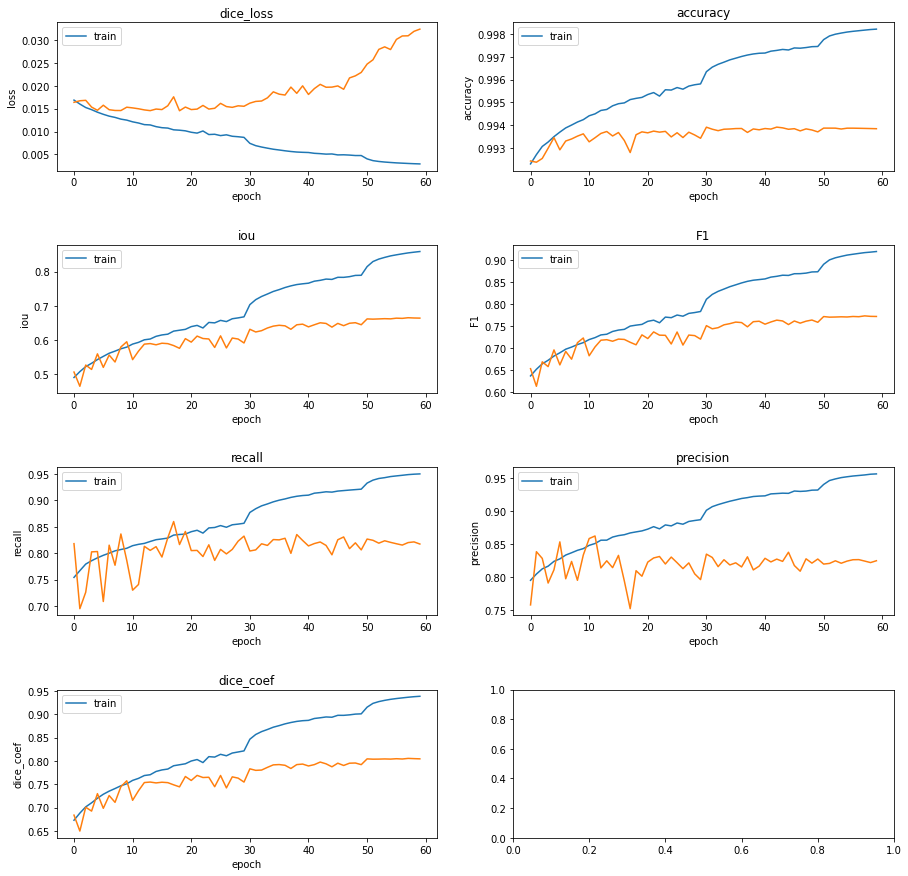

In [ ]:
#training code for half-UNet (The output is for the base half-UNet model)
train_gen = DataGen(train_ids, 'training/', image_size=image_size, batch_size=btch_size)
valid_gen = DataGen(validation_ids, 'validation/', image_size=image_size, batch_size=btch_size)
train_steps = len(train_ids)//btch_size
valid_steps = len(validation_ids)//btch_size
half_unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy', iou, F1, recall, precision, dice_coef])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = half_unet_model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=60, callbacks=[callback])
training_history_plot(history)
half_unet_model.save('half_unet')

Unet Model Training

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
2445/2445 [==============================] - 202s 81ms/step - loss: 0.0383 - accuracy: 0.9857 - iou: 0.2463 - F1: 0.3698 - recall: 0.4337 - precision: 0.5868 - dice_coef: 0.3950 - val_loss: 0.0288 - val_accuracy: 0.9874 - val_iou: 0.2760 - val_F1: 0.4109 - val_recall: 0.3587 - val_precision: 0.8308 - val_dice_coef: 0.4517
Epoch 2/60
2445/2445 [==============================] - 199s 81ms/step - loss: 0.0239 - accuracy: 0.9892 - iou: 0.3756 - F1: 0.5231 - recall: 0.6547 - precision: 0.7320 - dice_coef: 0.5617 - val_loss: 0.0422 - val_accuracy: 0.9888 - val_iou: 0.3050 - val_F1: 0.4138 - val_recall: 0.4449 - val_precision: 0.7497 - val_dice_coef: 0.4922
Epoch 3/60
2445/2445 [==============================] - 200s 82ms/step - loss: 0.0206 - accuracy: 0.9906 - iou: 0.4297 - F1: 0.5790 - recall: 0.7179 - precision: 0.7544 - dice_coef: 0.6166 - val_loss: 0.0227 - val_accuracy: 0.9902 - val_iou: 0.4476 - val_F1: 0.5883 - val_recall: 0.7299 - val_precision: 0.7033 - val_dice_coef: 0.

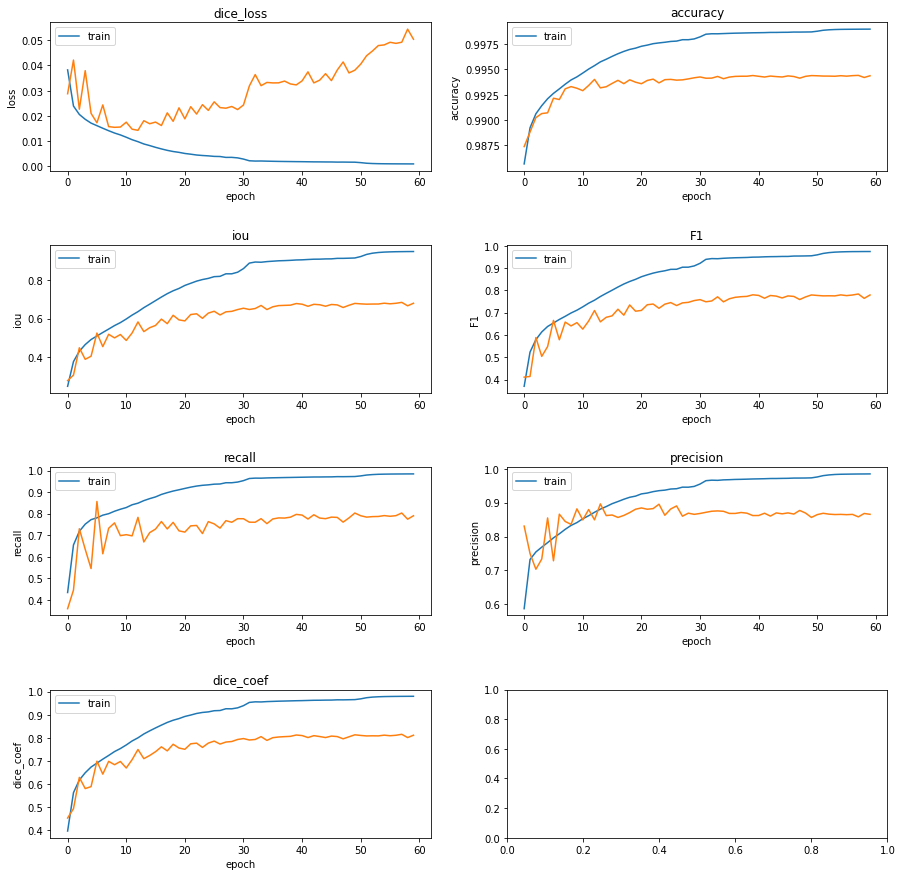

In [ ]:
#training code for UNet
train_gen = DataGen(train_ids, 'training/', image_size=image_size, batch_size=btch_size)
valid_gen = DataGen(validation_ids, 'validation/', image_size=image_size, batch_size=btch_size)
train_steps = len(train_ids)//btch_size
valid_steps = len(validation_ids)//btch_size
unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy', iou, F1, recall, precision, dice_coef])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = unet_model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=60, callbacks=[callback])
training_history_plot(history)
unet_model.save('unet')

Nested Half-Unet Model Training

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
2445/2445 [==============================] - 187s 73ms/step - loss: 0.0337 - accuracy: 0.9874 - iou: 0.3104 - F1: 0.4405 - recall: 0.5313 - precision: 0.6678 - dice_coef: 0.4743 - val_loss: 0.0280 - val_accuracy: 0.9877 - val_iou: 0.3058 - val_F1: 0.4511 - val_recall: 0.4461 - val_precision: 0.8054 - val_dice_coef: 0.4734
Epoch 2/60
2445/2445 [==============================] - 176s 72ms/step - loss: 0.0188 - accuracy: 0.9915 - iou: 0.4580 - F1: 0.6050 - recall: 0.7292 - precision: 0.7784 - dice_coef: 0.6443 - val_loss: 0.0171 - val_accuracy: 0.9921 - val_iou: 0.5011 - val_F1: 0.6418 - val_recall: 0.7782 - val_precision: 0.7591 - val_dice_coef: 0.6813
Epoch 3/60
2445/2445 [==============================] - 176s 72ms/step - loss: 0.0171 - accuracy: 0.9922 - iou: 0.4892 - F1: 0.6356 - recall: 0.7552 - precision: 0.7935 - dice_coef: 0.6737 - val_loss: 0.0173 - val_accuracy: 0.9923 - val_iou: 0.4810 - val_F1: 0.6234 - val_recall: 0.7319 - val_precision: 0.7990 - val_dice_coef: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2445/2445 [==============================] - 172s 70ms/step - loss: 0.0026 - accuracy: 0.9983 - iou: 0.8755 - F1: 0.9297 - recall: 0.9572 - precision: 0.9602 - dice_coef: 0.9465 - val_loss: 0.0249 - val_accuracy: 0.9948 - val_iou: 0.7099 - val_F1: 0.8081 - val_recall: 0.8440 - val_precision: 0.8556 - val_dice_coef: 0.8367
Epoch 44/60
1979/2445 [=======================>......] - ETA: 32s - loss: 0.0026 - accuracy: 0.9984 - iou: 0.8754 - F1: 0.9297 - recall: 0.9571 - precision: 0.9601 - dice_coef: 0.9463

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2445/2445 [==============================] - 174s 71ms/step - loss: 0.0025 - accuracy: 0.9984 - iou: 0.8773 - F1: 0.9307 - recall: 0.9577 - precision: 0.9610 - dice_coef: 0.9472 - val_loss: 0.0253 - val_accuracy: 0.9948 - val_iou: 0.7061 - val_F1: 0.8050 - val_recall: 0.8374 - val_precision: 0.8569 - val_dice_coef: 0.8338
Epoch 46/60
2445/2445 [==============================] - 177s 72ms/step - loss: 0.0025 - accuracy: 0.9984 - iou: 0.8800 - F1: 0.9325 - recall: 0.9593 - precision: 0.9614 - dice_coef: 0.9486 - val_loss: 0.0263 - val_accuracy: 0.9948 - val_iou: 0.7109 - val_F1: 0.8088 - val_recall: 0.8479 - val_precision: 0.8511 - val_dice_coef: 0.8369
Epoch 47/60
2445/2445 [==============================] - 174s 71ms/step - loss: 0.0025 - accuracy: 0.9984 - iou: 0.8806 - F1: 0.9328 - recall: 0.9594 - precision: 0.9616 - dice_coef: 0.9489 - val_loss: 0.0266 - val_accuracy: 0.9947 - val_iou: 0.7068 - val_F1: 0.8053 - val_recall: 0.8528 - val_precision: 0.8423 - val_dice_coef: 0.8344
Epoc

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


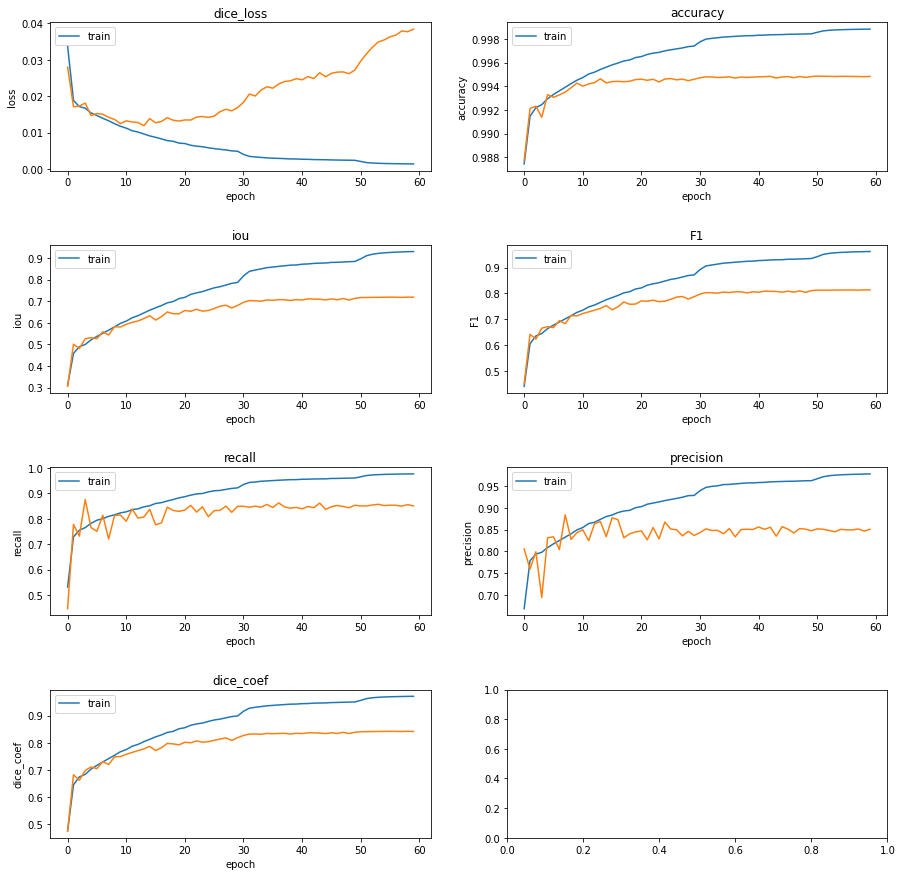

In [ ]:
#training code for Nested half-UNet
train_gen = DataGen(train_ids, 'training/', image_size=image_size, batch_size=btch_size)
valid_gen = DataGen(validation_ids, 'validation/', image_size=image_size, batch_size=btch_size)
train_steps = len(train_ids)//btch_size
valid_steps = len(validation_ids)//btch_size
nested_half_unet.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy', iou, F1, recall, precision, dice_coef])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = nested_half_unet.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=60, callbacks=[callback])
training_history_plot(history)
nested_half_unet.save('nested_half_unet')

Half-Unet Model Training with L2 Regularization

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-14 06:23:37.515671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-11-14 06:23:41.432037: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2445/2445 [==============================] - 308s 122ms/step - loss: 0.0547 - accuracy: 0.9873 - iou: 0.2913 - F1: 0.4228 - recall: 0.4887 - precision: 0.6332 - dice_coef: 0.4545 - val_loss: 0.0313 - val_accuracy: 0.9895 - val_iou: 0.3383 - val_F1: 0.4861 - val_recall: 0.5608 - val_precision: 0.7849 - val_dice_coef: 0.5170
Epoch 2/60
2445/2445 [==============================] - 275s 113ms/step - loss: 0.0288 - accuracy: 0.9898 - iou: 0.3804 - F1: 0.5254 - recall: 0.6474 - precision: 0.7493 - dice_coef: 0.5668 - val_loss: 0.0311 - val_accuracy: 0.9880 - val_iou: 0.4212 - val_F1: 0.5622 - val_recall: 0.8133 - val_precision: 0.6111 - val_dice_coef: 0.5978
Epoch 3/60
2445/2445 [==============================] - 274s 112ms/step - loss: 0.0266 - accuracy: 0.9902 - iou: 0.3989 - F1: 0.5445 - recall: 0.6635 - precision: 0.7592 - dice_coef: 0.5849 - val_loss: 0.0255 - val_accuracy: 0.9906 - val_iou: 0.4112 - val_F1: 0.5590 - val_recall: 0.7791 - val_precision: 0.7020 - val_dice_coef: 0.5929
Epo

2022-11-14 10:59:08.629348: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


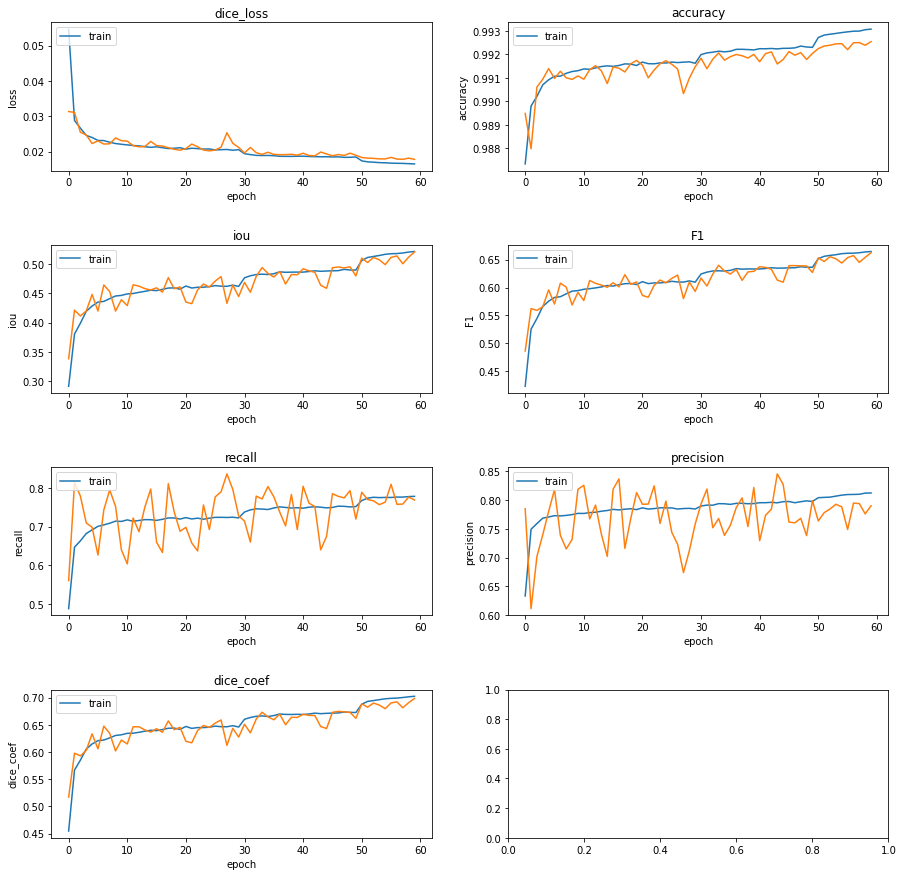

In [ ]:
#training code for half-UNet (The output is for the half-UNet model with L2 Regularization)
train_gen = DataGen(train_ids, 'training/', image_size=image_size, batch_size=btch_size)
valid_gen = DataGen(validation_ids, 'validation/', image_size=image_size, batch_size=btch_size)
train_steps = len(train_ids)//btch_size
valid_steps = len(validation_ids)//btch_size
half_unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy', iou, F1, recall, precision, dice_coef])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = half_unet_model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=60, callbacks=[callback])
training_history_plot(history)
half_unet_model.save('half_unet_reg')

Half-Unet Model Training with Batch Normalization

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-14 14:31:30.176935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-11-14 14:31:34.279999: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2445/2445 [==============================] - 126s 47ms/step - loss: 0.0368 - accuracy: 0.9869 - iou: 0.3185 - F1: 0.4499 - recall: 0.5596 - precision: 0.6634 - dice_coef: 0.4825 - val_loss: 0.0305 - val_accuracy: 0.9869 - val_iou: 0.2893 - val_F1: 0.4316 - val_recall: 0.3213 - val_precision: 0.8839 - val_dice_coef: 0.4601
Epoch 2/60
2445/2445 [==============================] - 108s 44ms/step - loss: 0.0188 - accuracy: 0.9915 - iou: 0.4586 - F1: 0.6075 - recall: 0.7325 - precision: 0.7788 - dice_coef: 0.6449 - val_loss: 0.0184 - val_accuracy: 0.9915 - val_iou: 0.4368 - val_F1: 0.5806 - val_recall: 0.6244 - val_precision: 0.8335 - val_dice_coef: 0.6294
Epoch 3/60
2445/2445 [==============================] - 108s 44ms/step - loss: 0.0171 - accuracy: 0.9922 - iou: 0.4882 - F1: 0.6351 - recall: 0.7571 - precision: 0.7921 - dice_coef: 0.6724 - val_loss: 0.0167 - val_accuracy: 0.9924 - val_iou: 0.4888 - val_F1: 0.6379 - val_recall: 0.7335 - val_precision: 0.8080 - val_dice_coef: 0.6699
Epoch 

2022-11-14 16:22:32.264950: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


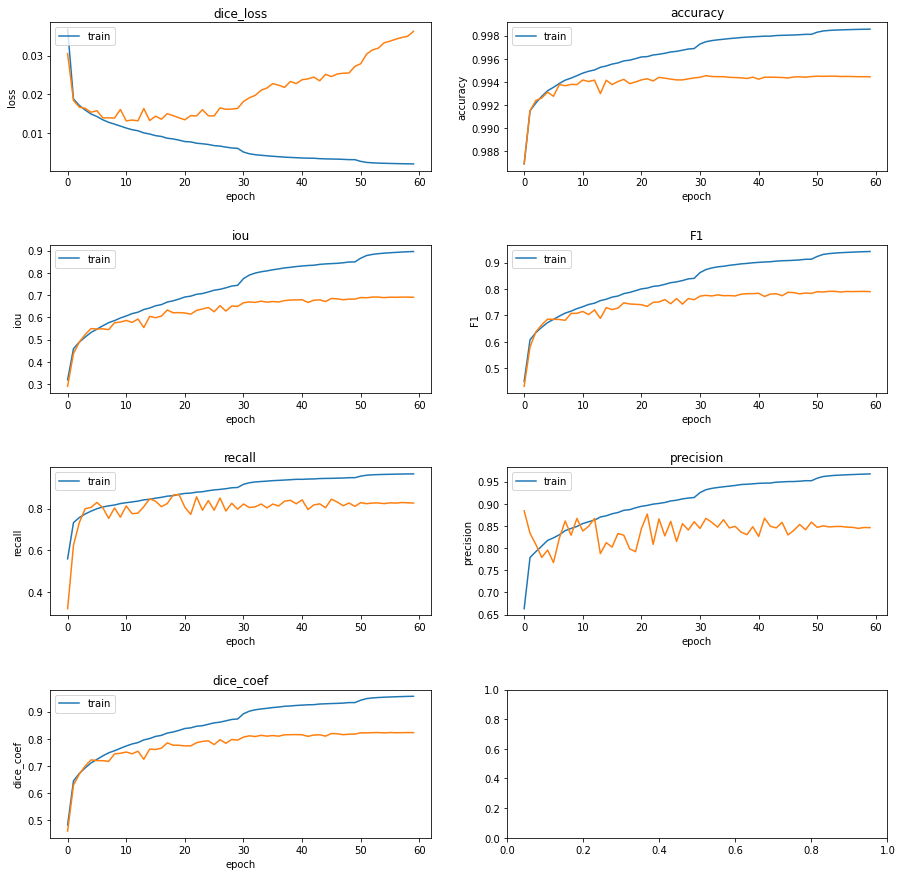

In [ ]:
#training code for half-UNet (The output is for the half-UNet model with Batch Normalization)
train_gen = DataGen(train_ids, 'training/', image_size=image_size, batch_size=btch_size)
valid_gen = DataGen(validation_ids, 'validation/', image_size=image_size, batch_size=btch_size)
train_steps = len(train_ids)//btch_size
valid_steps = len(validation_ids)//btch_size
half_unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy', iou, F1, recall, precision, dice_coef])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = half_unet_model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=60, callbacks=[callback])
training_history_plot(history)
half_unet_model.save('half_unet_norm')

Model loading, evaluation and result visualization

In [10]:

all_mods = ['half_unet', 'half_unet_reg', 'half_unet_norm', 'unet', 'nested_half_unet']

btch_size = 2
image_size = 256

train_path = FOLDER_PATH + "training/images/img"
test_path = FOLDER_PATH + "testing/images/img"
validation_path = FOLDER_PATH + "validation/images/img"

train_ids = os.listdir(train_path)
validation_ids = os.listdir(validation_path)
test_ids = os.listdir(test_path)

def iou(y_true, y_pred, smooth=1):
	intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
	union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
	iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
	return iou

def F1(y_true, y_pred, smooth=1):
	intersection = K.sum(y_true * y_pred, axis=[1,2,3])
	union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
	dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
	return dice

def recall(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + K.epsilon())
	return recall

def precision(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
	precision = true_positives / (predicted_positives + K.epsilon())
	return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def load_model(model_name):
  #loading model
  return keras.models.load_model(FOLDER_PATH + "Trained_Models/" + model_name, custom_objects ={'iou':iou, 'F1':F1, 'recall':recall, 'precision':precision, 'dice_coef':dice_coef})

def load_models(model_name = 'all'):
  #loading all or specific model based on choice
  if model_name == 'all':
    nested_half_unet = load_model('nested_half_unet')
    half_unet_reg = load_model('half_unet_reg')
    half_unet = load_model('half_unet')
    half_unet_norm = load_model('half_unet_norm')
    unet = load_model('unet')
    print("ALL Models Loaded Successfully")
    return [half_unet, half_unet_reg, half_unet_norm, unet, nested_half_unet]
  print(model_name, "Loaded Successfully")
  return load_model(model_name)

def load_test_data(batch_size = 10):
  #loading test generator
  test_ids = os.listdir(test_path)
  gen = DataGen(test_ids, "testing/", batch_size=batch_size, image_size=image_size)
  print("Test Data Loaded")
  return gen, len(test_ids)

def visualize_output(x, y, y_pred, tot, idx, fig, title_flag = False):
  #visualizing model outputs from different models
  contours1, hierarchy = cv2.findContours(y[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contours2, hierarchy = cv2.findContours(y_pred[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(x[0], contours1, -1, (0, 255, 0), 3)
  cv2.drawContours(x[0], contours2, -1, (255, 0, 0), 3)
  ax = fig.add_subplot(tot, 5, idx)
  # if title_flag:
  ax.set_title(all_mods[idx - 1], fontdict={'fontsize': 20, 'fontweight': 'medium'})
  ax.imshow(np.reshape(x[0], (image_size, image_size, 3)))

def visualize_outputs_of__all_models(gen, all_models, start = 0, test_img_count = 10):
  #visualizing outputs for all the models for specific number of input images
  for i in range(start, start + test_img_count):
    x, y = gen.__getitem__(i)
    fig = plt.figure(figsize=(25,25))
    for idx, mod in enumerate(all_models):
      y_pred = mod.predict(x, verbose = 0)
      visualize_output(x.copy(), y, y_pred, test_img_count, idx+1, fig, i==start)
  plt.show()

def evaluate_all_models(gen, all_models, num_tests):
  #evaluating all models
  valid_ids = os.listdir(validation_path)
  gen = DataGen(valid_ids, "validation/", batch_size=1, image_size=image_size)
  num_tests = len(valid_ids)
  for idx, mod in enumerate(all_models):
    out = mod.evaluate_generator(gen, steps = num_tests)
    print(all_mods[idx], out[-1])

In [11]:
all_models = load_models() # pass any of the following as a string to load the specific model : 'half_unet', 'half_unet_reg', 'half_unet_norm', 'unet', 'nested_half_unet'
gen, num_tests = load_test_data(1) # pass any number higher than 1 which represents the batch_size for the data generator

ALL Models Loaded Successfully
Test Data Loaded


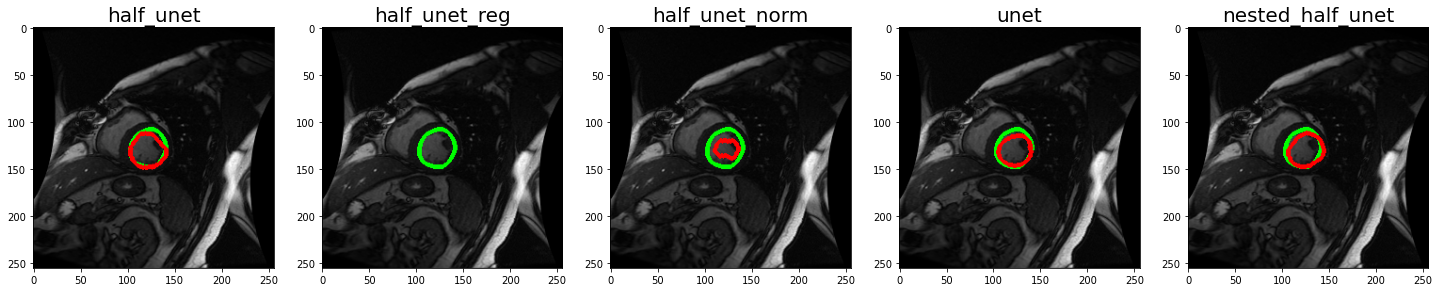

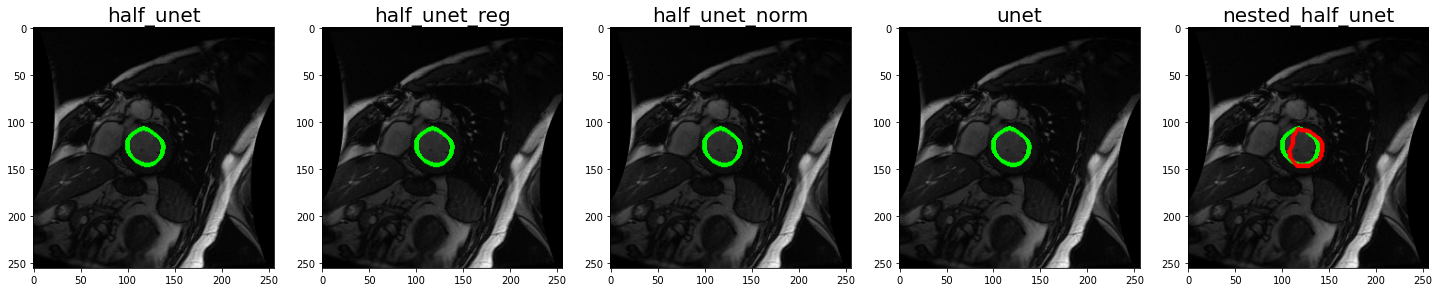

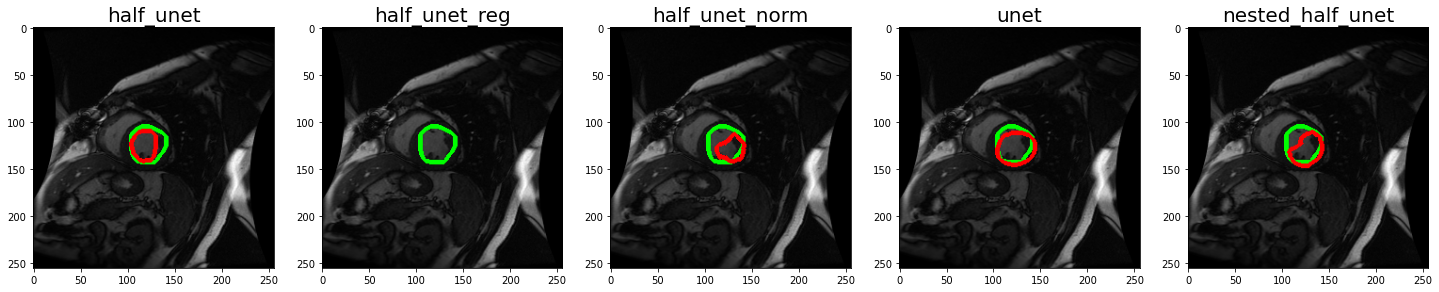

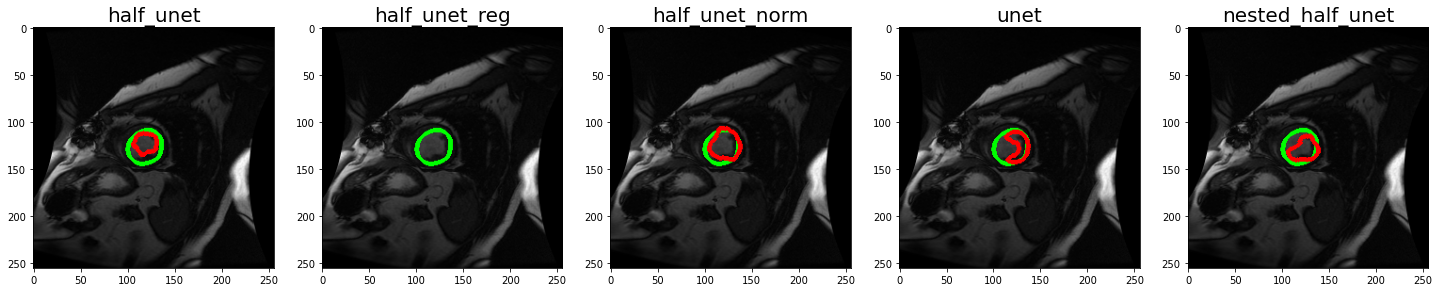

In [12]:
#to check the output on different data run the below model with start which is the start index and test_img_count which is the total images to test on
#we have total 266 images in the testing set so the start can be anything between 0 and 265 (inclusive)
#Example : start = 3 and test_img_count = 4 means starting from image number 4 and including 4 images from there
visualize_outputs_of__all_models(gen, all_models, start = 3, test_img_count = 4) 

In [ ]:
evaluate_all_models(gen, all_models, num_tests)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


half_unet 0.7711232900619507
half_unet_reg 0.6621906161308289
half_unet_norm 0.78990638256073
unet 0.7789193987846375
nested_half_unet 0.8131551742553711
